9412
654
{('TP53', 'PIK3CA'): 4, ('TP53', 'CDH1'): 3, ('TP53', 'ARID1A'): 3, ('TP53', 'NF1'): 3, ('TP53', 'KRAS'): 3, ('TP53', 'MAP3K1'): 2, ('TP53', 'FOXA1'): 2, ('TP53', 'AKT1'): 2, ('TP53', 'MAP2K4'): 2, ('TP53', 'NCOR1'): 2, ('TP53', 'KDM5C'): 2, ('TP53', 'HUWE1'): 2, ('TP53', 'PLCB4'): 2, ('TP53', 'PLXNB2'): 2, ('TP53', 'CIC'): 2, ('TP53', 'EGFR'): 2, ('TP53', 'APOB'): 4, ('PIK3CA', 'AKT1'): 2, ('PIK3CA', 'MACF1'): 4, ('PIK3CA', 'NF1'): 4, ('PIK3CA', 'KMT2C'): 4, ('NF1', 'IDH1'): 2, ('NF1', 'APOB'): 4, ('PTEN', 'IDH1'): 2, ('IDH1', 'EGFR'): 2, ('KMT2C', 'KMT2D'): 6, ('KMT2C', 'MACF1'): 6, ('KMT2C', 'APOB'): 4, ('KMT2D', 'ATM'): 5, ('KMT2D', 'DMD'): 5, ('KMT2D', 'SPTA1'): 4, ('KMT2D', 'MED12'): 4, ('MACF1', 'APOB'): 6, ('MACF1', 'SPTA1'): 5, ('MACF1', 'ERBB4'): 5, ('MACF1', 'FAT1'): 4, ('APOB', 'CACNA1A'): 6, ('APOB', 'EPHA3'): 5, ('APOB', 'PIK3CG'): 5, ('APOB', 'COL5A1'): 4, ('APOB', 'ERBB4'): 4, ('APOB', 'FAT1'): 4, ('APOB', 'SPTA1'): 4, ('APOB', 'ZFHX3'): 4, ('APOB', 'ATM'): 4, 

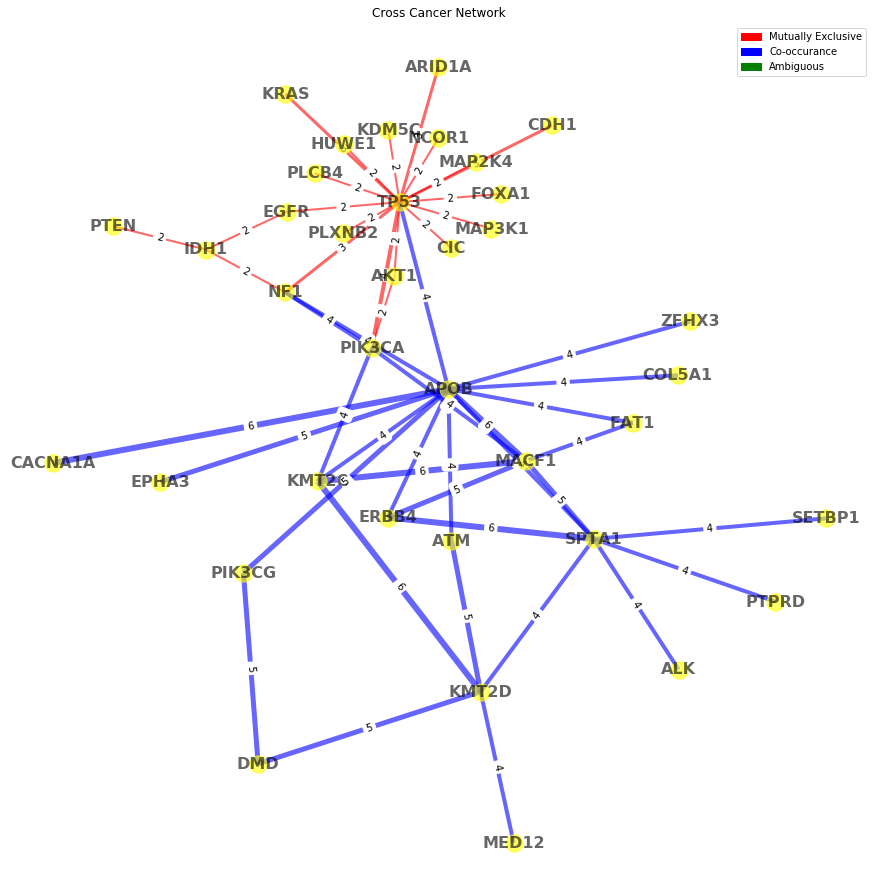

In [76]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

# cancerList = ["BRCA", "GBM", "LAML", "LGG", "LIHC", "KIRP", "KIRC", \
#               "CESC", "STAD", "SKCM", "SARC", "PAAD", "LUSC", "LUAD", \
#               "UCEC"]

cancerList = ["BLCA","BRCA", "GBM", "LGG", "LIHC", "KIRC", \
              "CESC", "SKCM", "PAAD", "LUSC", "LUAD", \
              "UCEC", "STAD"]
# cancerList = ["BLCA", "BRCA"]
ME_dic={}
Co_dic={}
for myCancer in cancerList:
    ####### Mutually Exclusive Red Edges ##########
    file_n = myCancer + '/' + myCancer + "_mut.csv"
    with open(file_n, newline='') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            key=row[1]+'-'+row[2]
            key_rev=row[2]+'-'+row[1]
            if (key not in ME_dic) and (key_rev not in ME_dic): 
                ME_dic[key]=1
            else: ME_dic[key]+=1

    ####### Co-occurance Blue Edges ##########
    file_n = myCancer + '/' + "bigSummaryDf_" + myCancer + ".csv"
    if myCancer == 'BLCA':
        file_n = "BLCA/bigSummaryDfw_cutoff_BLCA.csv"
    if myCancer=='PAAD'or myCancer=='LUSC'or myCancer =='LUAD':
        file_n = myCancer + '/' + "bigSummaryDf_2ndtry" + myCancer + ".csv"
    data = pd.read_csv(file_n)
    for idx, row in data.iterrows():
        if row["co_occurance"] >= row["co_cut"] and row['pval']<0.05:
            n1 = row['gene1']
            n2 = row['gene2']
            key=n1+'-'+n2
            key_rev=n2+'-'+n1
            if (key not in Co_dic) and (key_rev not in Co_dic): 
                Co_dic[key]=1
            else: Co_dic[key]+=1

print(len(Co_dic))
print(len(ME_dic))

###### Setting Graph with ME_dic and Co_dic ######
G = nx.Graph()
import operator
ME = sorted(ME_dic.items(), key=operator.itemgetter(1), reverse=True)
Co = sorted(Co_dic.items(), key=operator.itemgetter(1), reverse=True)
ME_count = 0
Co_count = 0
for key, value in ME:
    ME_count+=1
    g1=key.split("-",1)[0]
    g2=key.split("-",1)[1]
    G.add_edge(g1, g2, color='r', weight=value, r=value)
    if ME_count >= 20: break
for key, value in Co:
    Co_count+=1
    g1=key.split("-",1)[0]
    g2=key.split("-",1)[1]
    if G.has_edge(g1, g2):
        G.add_edge(g1, g2, color='g')
    else:
        G.add_edge(g1, g2, color='b', weight=value, r=value)
    if Co_count >= 30: break

# pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)



####### Plotting
edges = G.edges()

colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
edge_labels = nx.get_edge_attributes(G, 'r')

plt.figure(figsize=(12,12))
nx.draw(G, pos, node_color='yellow', with_labels=True, \
        font_size=16, node_size=300, font_weight='bold', alpha=0.6, \
        edges=edges, edge_color=colors, width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Cross Cancer Network")
red = mpatches.Patch(color='red', label='Mutually Exclusive')
blue = mpatches.Patch(color='blue', label='Co-occurance')
green = mpatches.Patch(color='green', label='Ambiguous')
plt.legend(handles=[red, blue, green])
plt.savefig('Total_net.png', bbox_inches="tight")
plt.show()